In [1]:
import pandas as pd
from pycaret.datasets import get_data
from pycaret.classification import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('Back_Test_Result.csv')
dataset.shape

(1000, 10)

In [3]:
dataset.head()

,Candle_No,Current_Market_Fit,Current_Market,Current_Market_Stoploss,Rec1,Rec1_P,Rec2,Rec2_P,Rec3,Rec3_P
0,7471.0,7.0,Bearish,0.0,50.0,BUY,97.0,SELL,64.0,BUY
1,2266.0,8.0,Bearish,0.0,51.0,SELL,66.0,BUY,99.0,SELL
2,3273.0,81.0,Bullish,0.0,67.0,BUY,60.0,BUY,8.0,SELL
3,6415.0,75.0,Bearish,0.0,63.0,BUY,91.0,BUY,22.0,SELL
4,7960.0,26.0,Bullish,0.0,42.0,BUY,14.0,BUY,72.0,SELL


## One-Hot Encoding

In [4]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_P'] = dataset['Rec1_P'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_P'] = dataset['Rec2_P'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_P'] = dataset['Rec3_P'].replace(['BUY','SELL'],[1,-1])

In [5]:
dataset['Rec1'] = dataset['Rec1'] * dataset['Rec1_P']
dataset['Rec2'] = dataset['Rec2'] * dataset['Rec2_P']
dataset['Rec3'] = dataset['Rec3'] * dataset['Rec3_P']

In [6]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Current_Market_Stoploss',
#    'Rec1',
    'Rec1_P',
#    'Rec2',
    'Rec2_P',
#    'Rec3',
    'Rec3_P'
], axis=1)

In [7]:
dataset.head()

,Current_Market,Rec1,Rec2,Rec3
0,0,50.0,-97.0,64.0
1,0,-51.0,66.0,-99.0
2,1,67.0,60.0,-8.0
3,0,63.0,91.0,-22.0
4,1,42.0,14.0,-72.0


In [8]:
data = dataset.sample(frac=0.70, random_state=950).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (700, 4)
Unseen Data For Predictions: (300, 4)


In [9]:
data_unseen.head()

,Current_Market,Rec1,Rec2,Rec3
0,0,80.0,-62.0,100.0
1,0,99.0,-97.0,-100.0
2,1,-99.0,2.0,-0.0
3,0,-0.0,-92.0,96.0
4,0,-0.0,-100.0,36.0


# Create Unseen DataFrame

In [10]:
#data_unseen = pd.DataFrame ({'Rec1': [-60.0], 'Rec2': [64.0], 'Rec3':[1.0]})

In [11]:
data_unseen.head()

,Current_Market,Rec1,Rec2,Rec3
0,0,80.0,-62.0,100.0
1,0,99.0,-97.0,-100.0
2,1,-99.0,2.0,-0.0
3,0,-0.0,-92.0,96.0
4,0,-0.0,-100.0,36.0


In [12]:
exp_clf101 = setup(data = data, target = 'Current_Market', session_id=123, silent=True) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(700, 4)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [13]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.5378,0.5517,0.4906,0.5152,0.5012,0.0707,0.0711,0.0430
lightgbm,Light Gradient Boosting Machine,0.5338,0.5204,0.4946,0.5090,0.5008,0.0626,0.0622,0.0100
dt,Decision Tree Classifier,0.5257,0.5245,0.5042,0.5007,0.5009,0.0486,0.0487,0.0050
et,Extra Trees Classifier,0.5216,0.5391,0.4819,0.4991,0.4886,0.0393,0.0398,0.0380
nb,Naive Bayes,0.5092,0.4895,0.3293,0.4830,0.3872,0.0040,0.0046,0.1130
lda,Linear Discriminant Analysis,0.5053,0.4788,0.3167,0.4843,0.3742,-0.0043,-0.0017,0.0040
lr,Logistic Regression,0.5032,0.4790,0.3167,0.4809,0.3733,-0.0083,-0.0060,0.2040
ridge,Ridge Classifier,0.5032,0.0000,0.3167,0.4809,0.3733,-0.0083,-0.0060,0.0040
svm,SVM - Linear Kernel,0.5011,0.0000,0.4797,0.4850,0.4771,0.0025,0.0007,0.0040
qda,Quadratic Discriminant Analysis,0.4970,0.4843,0.2998,0.4602,0.3535,-0.0211,-0.0230,0.0040


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [14]:
MODEL = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6531,0.6450,0.6667,0.6400,0.6531,0.3064,0.3067
1,0.5102,0.5533,0.5417,0.5000,0.5200,0.0216,0.0217
2,0.4694,0.4700,0.5000,0.4615,0.4800,-0.0599,-0.0601
3,0.5714,0.5733,0.5417,0.5652,0.5532,0.1418,0.1419
4,0.4898,0.4849,0.4348,0.4545,0.4444,-0.0268,-0.0268
5,0.3673,0.2625,0.2174,0.2778,0.2439,-0.2862,-0.2926
6,0.6122,0.5836,0.5217,0.6000,0.5581,0.2157,0.2173
7,0.5510,0.4716,0.4783,0.5238,0.5000,0.0941,0.0944
8,0.5714,0.6221,0.5217,0.5455,0.5333,0.1375,0.1376
9,0.5417,0.5374,0.5217,0.5217,0.5217,0.0817,0.0817


In [15]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.4694,0.5650,0.4583,0.4583,0.4583,-0.0617,-0.0617
1,0.6327,0.6917,0.5417,0.6500,0.5909,0.2625,0.2661
2,0.5102,0.5717,0.5417,0.5000,0.5200,0.0216,0.0217
3,0.5714,0.5517,0.5000,0.5714,0.5333,0.1404,0.1414
4,0.5918,0.5953,0.4783,0.5789,0.5238,0.1723,0.1747
5,0.4082,0.3177,0.3478,0.3636,0.3556,-0.1911,-0.1913
6,0.5102,0.5502,0.4783,0.4783,0.4783,0.0167,0.0167
7,0.5918,0.6120,0.5217,0.5714,0.5455,0.1765,0.1771
8,0.6122,0.6104,0.6522,0.5769,0.6122,0.2274,0.2291
9,0.5417,0.4904,0.5217,0.5217,0.5217,0.0817,0.0817


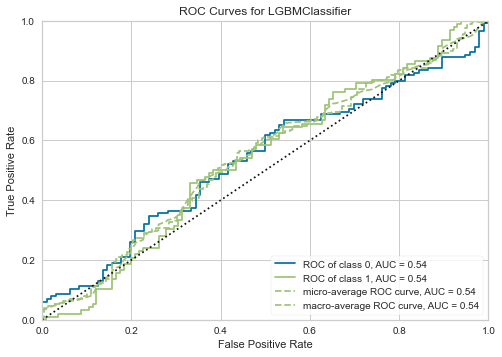

In [16]:
plot_model(TUNED_MODEL, plot = 'auc')

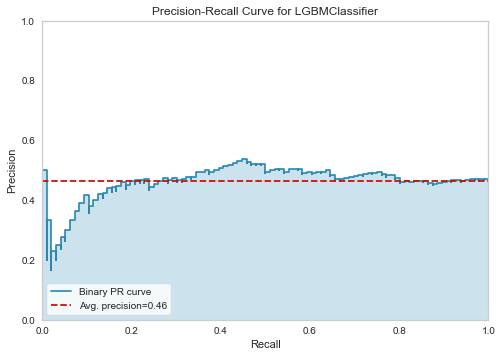

In [17]:
plot_model(TUNED_MODEL, plot = 'pr')

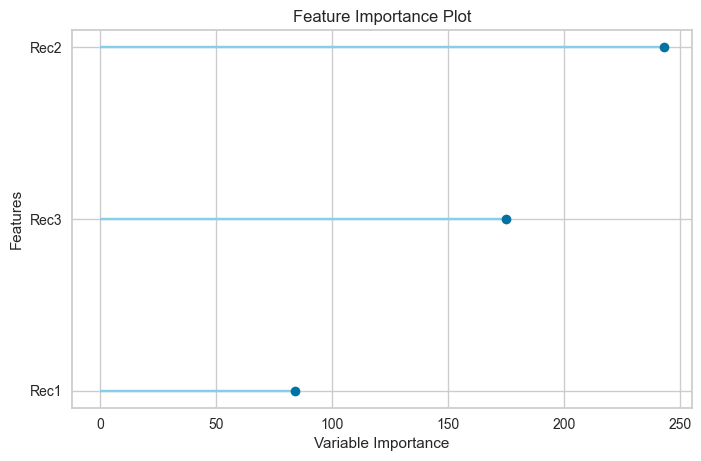

In [18]:
plot_model(TUNED_MODEL, plot='feature')

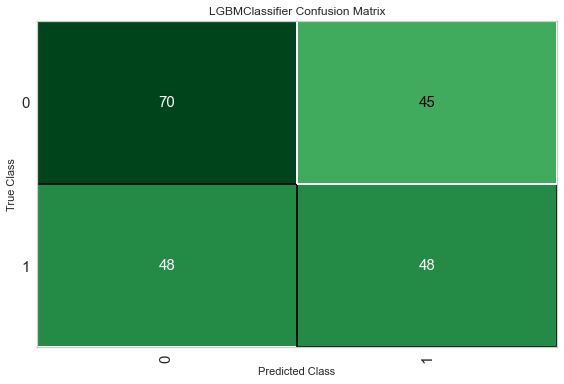

In [19]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [20]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.5592,0.5374,0.5000,0.5161,0.5079,0.1090,0.1090


In [21]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [22]:
print(FINAL_MODEL)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [23]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9384,0.9874,0.9375,0.9278,0.9326,0.8759,0.8759


In [24]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1,Rec2,Rec3,Label,Score
0,0,80.0,-62.0,100.0,0,0.8550
1,0,99.0,-97.0,-100.0,0,0.7352
2,1,-99.0,2.0,-0.0,1,0.5014
3,0,-0.0,-92.0,96.0,0,0.8593
4,0,-0.0,-100.0,36.0,0,0.8105


In [25]:
save_model(FINAL_MODEL,'FINAL_LIGHTGBM_17Nov2021_EURUSD')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                                 colsample_bytree=1.0, feature_fraction=0.5,
                                 importance_type='split', learning_rate=0.4,
                                 max_depth=-1, min_child_samples=6,
             

In [26]:
SAVED_FINAL_MODEL = load_model('FINAL_LIGHTGBM_17Nov2021_EURUSD')

Transformation Pipeline and Model Successfully Loaded


In [27]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [28]:
new_prediction.head(20)

,Current_Market,Rec1,Rec2,Rec3,Label,Score
0,0,80.0,-62.0,100.0,0,0.8550
1,0,99.0,-97.0,-100.0,0,0.7352
2,1,-99.0,2.0,-0.0,1,0.5014
3,0,-0.0,-92.0,96.0,0,0.8593
4,0,-0.0,-100.0,36.0,0,0.8105
5,0,-72.0,58.0,-87.0,0,0.9674
6,1,-65.0,-6.0,-7.0,0,0.5523
7,1,-23.0,-63.0,91.0,1,0.8845
8,1,61.0,99.0,-83.0,0,0.7054
9,1,-70.0,-1.0,87.0,1,0.6399


[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will b

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will b

[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will b

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will b